In [129]:
import pandas as pd
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
    #"font.family": "sans-serif",
    #"font.sans-serif": ["Computer Modern Serif"]
})
import tqdm
import sys
sys.path.append("../../")
from DynamicalSystems.kernels import RBF, Quadratic, Linear, Matern
from DynamicalSystems.reduced_rank_regression import KoopmanRegression
from DynamicalSystems.utils import plot_eigs
import seaborn as sns

def eigenvalues_timescale(eigenvalues, stride, timestep):
    eps = 1e-12
    data = []
    for ev in eigenvalues:
        decay_length = np.around((-np.log(np.abs(ev))**-1)*stride*timestep, decimals = 2)
        if np.abs(np.imag(ev)) < eps:
            #Real eigenvalue
            freq = None
            data.append((decay_length, freq))
        else:
            #Imaginary eigenvalue
            freq = np.around(2*np.pi*(np.angle(ev)**-1)*stride*timestep, decimals=2)
            data.append((decay_length, freq))
    return data

def print_timescale(eigenvalues, stride, timestep, units=''):
    data = eigenvalues_timescale(eigenvalues, stride, timestep) 
    col_width = max(len(str(_x[0]) + " " + units) for _x in data) + 2  # padding
    for x in data:
        if x[1] == None:
            print(f"Decay:{x[0]} {units}")
        elif x[1] <= 0:
            pass
        else:
            a = str(x[0]) + " " + units
            print("Decay: " + a.ljust(col_width) + f"Frequency: {x[1]} {units}")

#### Standardizing dataset

In [2]:
df_pd = pd.read_pickle("full_dataframe").interpolate().dropna()
#Get stations and measurements 
stations = set()
measurements = set()
for col in df_pd.columns:
    meas, stat = col.split("_")
    measurements.add(meas)
    stations.add(stat)

standardizing_parameters = dict() # (std, mean)

for m in measurements:
    std = df_pd.filter(regex= m + "_*").std().mean()
    mean = df_pd.filter(regex= m + "_*").mean().mean()
    standardizing_parameters[m] = (std, mean)

def scale(x, m, s):
    return (x - m)/s

def unscale(x, m, s):
    return x*s + m

#Scale measurements
df = dict()
for m in measurements:
    df[m] = (list(df_pd.filter(regex= m + "_*").columns), df_pd.filter(regex= m + "_*").apply(lambda x: scale(x, standardizing_parameters[m][1], standardizing_parameters[m][0])).to_numpy())

#### Selecting timestep, kernel, desired rank & regularizer

In [3]:
def extract_windows_vectorized(array,sub_window_size):
    #Sliding window every timestep, adapted from https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5
    max_time = array.shape[0] - sub_window_size
    sub_windows = (
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    )
    res = array[sub_windows]
    return res.reshape(res.shape[0], -1)

def subsample_data(df, n_timesteps, shift=0):
    #Select 1 data point every n_timesteps
    raised_exception = False
    dataset_indexes = []
    i = 0
    while not raised_exception:
        try:
            df[shift + i*n_timesteps]
            dataset_indexes.append(shift + i*n_timesteps)
            i += 1
        except Exception as e:
            raised_exception = True
    return df[np.array(dataset_indexes)]

def get_training_dataset(df, measurements, n_timesteps = None, history = None, average = False, shift = 0):
    if average:
        _cols = [m + "_mean" for m in measurements]
        _df = np.hstack([df[m][1].mean(axis=1)[:, np.newaxis] for m in measurements])
    else:
        _cols = [elem for sublist in [df[m][0] for m in measurements] for elem in sublist]
        _df = np.hstack([df[m][1] for m in measurements])
    #Applying subsampling and then sliding window
    if n_timesteps is not None:
        _df = subsample_data(_df, n_timesteps, shift = shift)
    if history is not None:
        _df = extract_windows_vectorized(_df, history)
        _cols_old = _cols
        _cols = [_cols_old[i] + " + " + str(j) for j in range(history) for i in range(len(_cols_old))]
    return _df, _cols

In [118]:
n_timesteps = 3 #In hours
regularizer = 1e-9
history = 9
average = False
_df, _cols = get_training_dataset(df, measurements, n_timesteps = n_timesteps, history = history, average = average)
l = np.float32(np.sqrt(_df.shape[1]))*3
X, Y = _df[:-1], _df[1:]
nu = 0.5
kernel = Matern(nu = nu, length_scale=l)
#kernel = Linear(coef0=0.)
num_samples = 2000
rank = 25
X_train, Y_train = X[:num_samples], Y[:num_samples]

In [119]:
K = KoopmanRegression(X_train, Y_train, kernel, regularizer, rank=rank, center_kernel=False, backend='cpu')

INIT: Computing low-rank-projection


In [33]:
#If history, mask everything but the last history timesteps
def mask_old_timesteps(array, measurement, history):
    idxs = []
    num_cols = array.shape[1]
    num_features = int(num_cols/history)
    for i,x in enumerate(_cols):
        if measurement in x:
            if i >= num_features*int(history - 1):
                idxs.append(i)
    return array[:, idxs]

### Forecasting

In [26]:
idx_0 = num_samples - 25
x_pred = [Y[idx_0]]
n_steps = 75
for _ in range(n_steps):
    x_pred.append(K.forecast(x_pred[-1]))
x_pred = np.array(x_pred)
x_true = Y[idx_0:(idx_0 + n_steps  +1)]

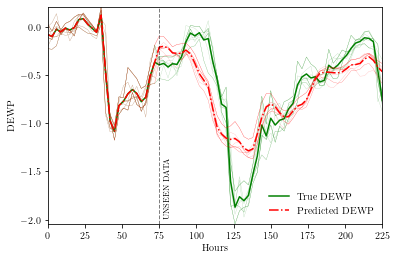

In [27]:
measurement = 'DEWP'
m_true = mask_old_timesteps(x_true, measurement, history)
m_pred = mask_old_timesteps(x_pred, measurement, history)
hours = np.linspace(0, n_steps*n_timesteps, n_steps + 1)
plt.plot(hours, m_true, 'g-', alpha = 0.3, lw=0.3)
plt.plot(hours, m_true.mean(axis=1), 'g-', label='True ' + measurement)
plt.plot(hours, m_pred, 'r-', alpha = 0.3, lw=0.3)
plt.plot(hours, m_pred.mean(axis=1), 'r-.', label='Predicted ' + measurement)
plt.axvline(x=n_timesteps*25, color='k', linestyle='--', lw=1, alpha = 0.5)
plt.text(x=n_timesteps*25 + 3, y = -2, s='UNSEEN DATA', rotation='vertical', fontsize=8, verticalalignment='bottom')
plt.ylabel(measurement)
plt.xlabel('Hours')
plt.margins(0)
plt.legend(frameon=False)
#plt.savefig("figs/predictions_" + measurement + ".pdf", bbox_inches='tight')

### Mode decomposition

In [120]:
dim = K.K_X.shape[0]
true_eigs = scipy.linalg.eigvals(K.K_YX, K.K_X + dim*regularizer*np.eye(dim))

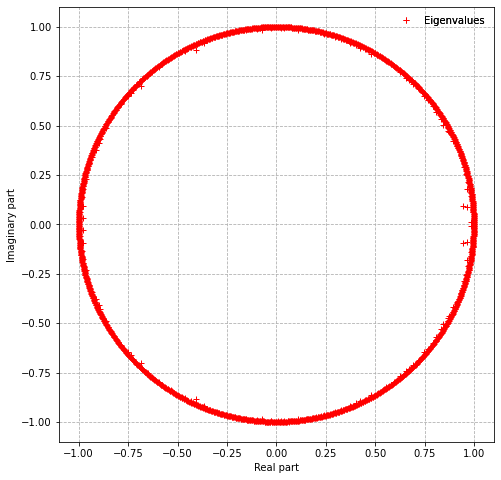

<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

In [121]:
C = K.K_YX@K.U
eigs, V_tilde =  scipy.linalg.eig(K.V.T@C)
D = (K.U.T)@K.K_X@K.U@V_tilde
#print_timescale(true_eigs, n_timesteps, 1, 'Hours')
plot_eigs(true_eigs)

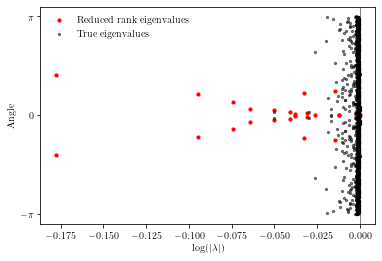

In [130]:
n = 1
plt.scatter(np.log(np.abs(eigs)), np.angle(eigs), c='r', s=10, label='Reduced rank eigenvalues')
plt.scatter(np.log(np.abs(true_eigs**n)), np.angle(true_eigs**n), c='k', s=5, alpha=0.5, label='True eigenvalues')
plt.axvline(x=0, color='k', lw=0.5)
plt.yticks([-np.pi, 0, np.pi], ['$-\pi$', '$0$', '$\pi$'])
plt.xlabel(r"$\log(\vert \lambda \vert)$")
plt.ylabel(r"Angle")
plt.legend(frameon=False)
plt.savefig("figs/eigs_comparison.pdf", bbox_inches='tight')

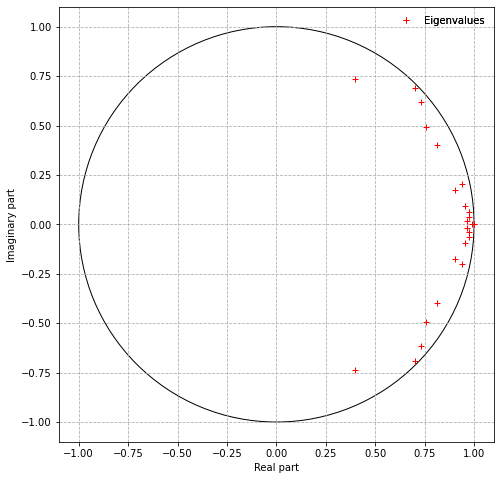

<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

In [117]:
plot_eigs(eigs)

In [35]:
modes = scipy.linalg.solve(D, K.U.T@K.X)
modes_PM25 = mask_old_timesteps(modes, "PM2.5", history)
modes_DEWP = mask_old_timesteps(modes, "DEWP", history)

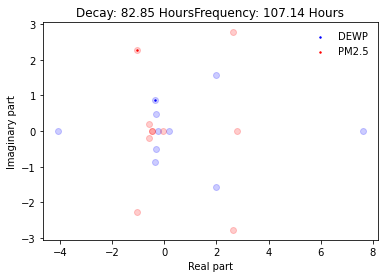

In [75]:
k = 2
data = eigenvalues_timescale(eigs, n_timesteps, 1)
units = 'Hours'
title = f"Decay: {data[k][0]} {units}"
if data[k][1] is not None:
    title+= f"Frequency: {data[k][1]} {units}"
plt.scatter(np.real(modes_DEWP).mean(axis=1), np.imag(modes_DEWP).mean(axis=1), color='b', alpha = 0.2)
plt.scatter(np.real(modes_PM25).mean(axis=1), np.imag(modes_PM25).mean(axis=1), color='r', alpha = 0.2)

plt.scatter(np.real(modes_DEWP).mean(axis=1)[k], np.imag(modes_DEWP).mean(axis=1)[k], color='b', s=2, label='DEWP')
plt.scatter(np.real(modes_PM25).mean(axis=1)[k], np.imag(modes_PM25).mean(axis=1)[k], color='r', s=2, label='PM2.5')
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title(title)
plt.legend(frameon=False)

#### Sine wave

In [ ]:
x = np.arange(0,10,0.01)
f = 2
y = np.sin(f*x)[:, np.newaxis]
_y = np.sin(f*x)
shift = 50
y_shift = np.empty((x.shape[0] -shift,2), dtype = x.dtype)
y_shift[:,0] = _y[:-shift]
y_shift[:,1] = _y[shift:]
kernel_RBF = RBF(length_scale=1)
kernel_linear = Linear(coef0=0.)
regularizer = 1e-6

In [ ]:
K = kernel_RBF.to_numpy(y[:-1])
K_shift = kernel_RBF.to_numpy(y_shift[:-1])

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize=(7,3))
ax[0].matshow(K, cmap='Greys')
ax[1].matshow(K_shift, cmap='Greys')
ax[0].set_title("Normal")
ax[1].set_title("Shifted")

In [ ]:
evals, evecs = reduced_rank_regression(y_shift[:-1], y_shift[1:], kernel_RBF, 8, regularizer)

In [ ]:
plot_eigs(evals)
print(np.imag(implied_timescale(evals,1,0.01)))

In [ ]:
implied_timescale(evals,1,0.01)

In [ ]:
K = kernel_RBF.to_numpy(y)
K_L = kernel_linear.to_numpy(y)

In [ ]:
plt.matshow(K)
plt.colorbar()